In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns

import pandas as pd
import numpy as np
from datetime import timedelta, datetime

In [2]:
# Get the route files
import subprocess
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/gtfs/2015/gtfs_nyct_bus_20150103.zip', 'gtfs_nyct_bus_20150103.zip'), shell=True)
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150128.csv.xz', 'bus_time_20150128.csv.xz'), shell=True)
subprocess.run("powershell Invoke-WebRequest {} -OutFile {}".format('http://data.mytransit.nyc.s3.amazonaws.com/bus_time/2015/2015-01/bus_time_20150129.csv.xz', 'bus_time_20150129.csv.xz'), shell=True)


import zipfile
import lzma
zip = zipfile.ZipFile('gtfs_nyct_bus_20150103.zip')
zip.extractall()

In [3]:
def convert_to_int64(row):
    try:
        return np.int64(row)
    except ValueError:
        return np.nan

def utc_to_est(row):
    try:
        return row - timedelta(hours=5)
    except:
        raise

csv_f = pd.read_csv
archive = pd.concat([csv_f("bus_time_20150128.csv"),
                     csv_f("bus_time_20150129.csv")])        
        
trips = pd.read_csv("trips.txt")
stops = pd.read_csv("stops.txt")
schedules = pd.read_csv("stop_times.txt")

C:\Users\parth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
archive.next_stop_id = archive.next_stop_id.apply(convert_to_int64)

In [5]:
#query and clean
live_archive = archive[archive.block_assigned > 0] # "assigned" to a route
today = live_archive[live_archive.service_date == 20150128] # due to time shift we get some dates in 1/27 and 1/29
#throw away trips with <15 reports
good_trips_only = today.groupby(today.trip_id).filter(lambda group: len(group) > 15)

#write this as our "clean" dataset
good_trips_only.to_csv("realtime.csv")

#merged dataframe with both 
partial = good_trips_only.merge(trips, on='trip_id') 
df = partial.merge(stops, left_on="next_stop_id", right_on="stop_id")

In [6]:
# Select one bus route 
pd.options.display.max_columns = None
m15_only = df[df.route_id.str.contains("M15")].reset_index()
m15_only["timestamp"] = pd.to_datetime(m15_only["timestamp"])

In [7]:
m15_reg = m15_only[m15_only.trip_id.str.contains("M15")].reset_index()
m15_sbs = m15_only[m15_only.trip_id.str.contains("SBS")].reset_index()

In [8]:
print('The number of regular M15 buses over 48 hours =',len(m15_reg.trip_id.unique()))
print('The number of express M15 buses over 48 hours =',len(m15_sbs.trip_id.unique()))

The number of regular M15 buses over 48 hours = 257
The number of express M15 buses over 48 hours = 335


In [9]:
m15_reg.stop_name.unique()

array(['2 AV/E 125 ST', '2 AV/E 122 ST', '2 AV/E 116 ST', '2 AV/E 113 ST',
       '2 AV/E 110 ST', '2 AV/E 106 ST', '2 AV/E 96 ST', '2 AV/E 91 ST',
       '2 AV/E 88 ST', '2 AV/E 84 ST', '2 AV/E 79 ST', '2 AV/E 75 ST',
       '2 AV/E 72 ST', '2 AV/E 66 ST', '2 AV/E 61 ST', '2 AV/E 57 ST',
       '2 AV/E 50 ST', '2 AV/E 46 ST', '2 AV/E 42 ST', '2 AV/E 39 ST',
       '2 AV/E 36 ST', '2 AV/E 31 ST', '2 AV/E 28 ST', '2 AV/E 25 ST',
       '2 AV/E 17 ST', '2 AV/E 14 ST', '2 AV/E 12 ST', '2 AV/E 9 ST',
       '2 AV/E 6 ST', 'ALLEN ST/CANAL ST', 'PIKE ST/MADISON ST',
       'MADISON ST/MARKET ST', 'MADISON ST/CATHERINE ST',
       'MADISON ST/ST JAMES PL', 'PEARL ST/FRANKFORT ST',
       'PEARL ST/FULTON ST', 'WATER ST/MAIDEN LA',
       'WATER ST/GOUVERNEUR LA', 'BROAD ST/WATER ST', 'WATER ST/BROAD ST',
       'WATER ST/OLD SLIP', 'WATER ST/WALL ST', 'PEARL ST/PECK SLIP',
       'PEARL ST/R F WAGNER SR PL', 'PIKE ST/DIVISION ST',
       'ALLEN ST/GRAND ST', 'ALLEN ST/DELANCEY ST', 'ALLEN ST/

In [10]:
m15_sbs.stop_name.unique()

array(['2 AV/E 125 ST', '2 AV/E 116 ST', '2 AV/E 88 ST', '2 AV/E 79 ST',
       '2 AV/E 57 ST', '2 AV/E 50 ST', '2 AV/E 42 ST', '2 AV/E 14 ST',
       'MADISON ST/CATHERINE ST', 'PEARL ST/FULTON ST', 'WATER ST/WALL ST',
       'ALLEN ST/GRAND ST', '1 AV/E 14 ST', '1 AV/E 23 ST',
       '1 AV/MITCHELL PL', '1 AV/E 57 ST', '1 AV/E 67 ST', '1 AV/E 79 ST',
       '1 AV/E 86 ST', '1 AV/E 105 ST', 'E 126 ST/2 AV', '2 AV/E 68 ST',
       '2 AV/E 34 ST', '2 AV/E 23 ST', '1 AV/E 28 ST', '1 AV/E 34 ST',
       '1 AV/E 42 ST', 'ALLEN ST/E HOUSTON ST', '1 AV/E 125 ST',
       '1 AV/E 116 ST', '2 AV/E 106 ST', '2 AV/E 100 ST', '2 AV/E 28 ST',
       'ALLEN ST/HESTER ST', 'SOUTH FERRY/TERMINAL', '1 AV/E 1 ST',
       '1 AV/E 25 ST', '1 AV/ E 97 ST', ' E HOUSTON ST/ELDERIDGE ST'], dtype=object)

In [11]:
# Analyze one Regular trip and one Express trip
trip_002000_M15_2 = m15_reg[m15_reg.trip_id.str.contains("002000_M15_2")].sort_values('timestamp')
trip_028500_SBS15_1 = m15_sbs[m15_sbs.trip_id.str.contains("029500_SBS15_2")].sort_values('timestamp')
trip_028500_SBS15_1
#trip_002000_M15_2.stop_name.unique()

,level_0,index,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
3,50,161899,2015-01-28 09:55:27,1285,40.803207,-73.932550,157.39,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401738,180.23,174.22,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401738,2 AV/E 125 ST,NaN,40.802494,-73.933891,NaN,NaN,0,NaN
419,1092,162941,2015-01-28 09:55:59,1285,40.802263,-73.933927,233.97,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,706.8,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
420,1093,162942,2015-01-28 09:56:30,1285,40.799534,-73.935936,234.75,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,359.39,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
421,1094,162943,2015-01-28 09:57:01,1285,40.796938,-73.937821,234.09,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,401741,910.98,29.95,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,401741,2 AV/E 116 ST,NaN,40.796745,-73.938095,NaN,NaN,0,NaN
19089,41979,1831904,2015-01-28 09:57:33,1285,40.795712,-73.938718,233.53,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405347,1660.3,623.44,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405347,2 AV/E 106 ST,NaN,40.790859,-73.942429,NaN,NaN,0,NaN
19090,41980,1831905,2015-01-28 09:58:07,1285,40.792976,-73.940718,233.43,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405347,1660.3,275.75,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405347,2 AV/E 106 ST,NaN,40.790859,-73.942429,NaN,NaN,0,NaN
19513,42403,1832328,2015-01-28 09:58:39,1285,40.790380,-73.942613,233.91,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,903103,2158.71,444.36,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN
19514,42404,1832329,2015-01-28 09:59:10,1285,40.790097,-73.942819,233.91,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,903103,2158.71,408.33,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN
19515,42405,1832330,2015-01-28 09:59:41,1285,40.789106,-73.943548,233.47,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,903103,2158.71,282.23,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,903103,2 AV/E 100 ST,NaN,40.786915,-73.945244,NaN,NaN,0,NaN
731,2705,164554,2015-01-28 10:00:14,1285,40.786764,-73.945261,233.68,0,20150128,OF_A5-Weekday-SDon-029500_SBS15_2,1,405307,3129.23,955.12,M15+,OF_A5-Weekday-SDon,SELECT BUS SERVICE SOUTH FERRY via 2 AV,1,SBS150060,405307,2 AV/E 88 ST,NaN,40.779278,-73.950821,NaN,NaN,0,NaN


In [12]:
print(len(trip_002000_M15_2.latitude))
print(len(trip_028500_SBS15_1))

63
67


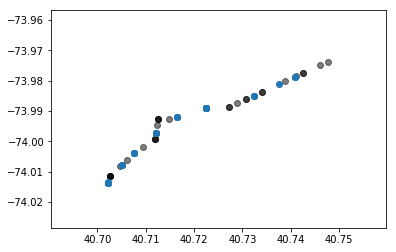

In [13]:
from matplotlib.pylab import plt
# Plot regular route
fig1 = plt.figure()
#plt.plot(trip_002000_M15_2.latitude[0:32], trip_002000_M15_2.longitude[0:32], '--', alpha=1)
plt.scatter(trip_002000_M15_2.stop_lat[32:63], trip_002000_M15_2.stop_lon[32:63], alpha=0.5, color = 'k')
# Plot express route
#fig2 = plt.figure()
#plt.plot(trip_028500_SBS15_1.latitude[0:35], trip_028500_SBS15_1.longitude[0:35], '--', alpha=0.75)
plt.scatter(trip_028500_SBS15_1.stop_lat[35:67], trip_028500_SBS15_1.stop_lon[35:67], alpha=1)

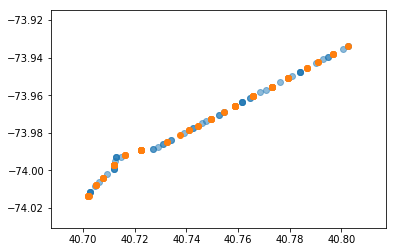

In [14]:
plt.scatter(trip_002000_M15_2.stop_lat, trip_002000_M15_2.stop_lon, alpha=0.5)
plt.scatter(trip_028500_SBS15_1.stop_lat, trip_028500_SBS15_1.stop_lon, alpha=1)

In [15]:
#Trip time
start_time = trip_002000_M15_2.timestamp[min(trip_002000_M15_2.index)]
end_time = trip_002000_M15_2.timestamp[max(trip_002000_M15_2.index)]

fmt = '%Y-%m-%d %H:%M:%S'
tstamp1 = datetime.strptime(start_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)
tstamp2 = datetime.strptime(end_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)

if tstamp1 > tstamp2:
    td = tstamp1 - tstamp2
else:
    td = tstamp2 - tstamp1
td_mins = int(round(td.total_seconds() / 60))

print('The trip time is approx. %s minutes' % td_mins)

#Average Speed
total_dist = max(trip_002000_M15_2.dist_along_route)

speed_in_meters = round(float(total_dist) / td_mins)
speed_in_mph = round(speed_in_meters * 0.000621371 * 60,2)

print('The average speed is approx. %s mph' % speed_in_mph)

The trip time is approx. 45 minutes
The average speed is approx. 8.09 mph


In [16]:
# Regular bus Min/Max/Avg Trip time
reg_trips = m15_reg.trip_id.unique()
N = len(reg_trips)

trip = {}
trip_times = {}
speeds = {}

for i in range (0,N): 
    #Store each unique trip_id
    trip[i] = m15_reg[m15_reg.trip_id.str.contains(reg_trips[i])].sort_values('timestamp')
    
    #Compute trip times
    start_time = trip[i].timestamp[min(trip[i].index)]
    end_time = trip[i].timestamp[max(trip[i].index)]
    
    fmt = '%Y-%m-%d %H:%M:%S'
    tstamp1 = datetime.strptime(start_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)
    tstamp2 = datetime.strptime(end_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)

    if tstamp1 > tstamp2:
        td = tstamp1 - tstamp2
    else:
        td = tstamp2 - tstamp1
    trip_times[i] = int(round(td.total_seconds() / 60))
    
    # Average speeds
    total_dist = max(trip[i].dist_along_route)

    speed_in_meters = round(float(total_dist) / td_mins)
    speeds[i] = round(speed_in_meters * 0.000621371 * 60,2)

In [17]:
trip_times.values()
max_time = max(trip_times.values())   
min_time = min(trip_times.values())
avg_time = round(sum(trip_times.values())/N)

print('The mininum trip was %i min, the maximum trip time was %i min, and the average trip was %i min' %(min_time,max_time,avg_time))

The mininum trip was 1 min, the maximum trip time was 155 min, and the average trip was 71 min


In [18]:
# SBS bus Min/Max/Avg Trip time 
sbs_trips = m15_sbs.trip_id.unique()
N = len(sbs_trips)

trip = {}
trip_times = {}
speeds = {}

for i in range (0,N): 
    #Store each unique trip_id
    trip[i] = m15_sbs[m15_sbs.trip_id.str.contains(sbs_trips[i])].sort_values('timestamp')
    
    #Compute trip times
    start_time = trip[i].timestamp[min(trip[i].index)]
    end_time = trip[i].timestamp[max(trip[i].index)]
    
    fmt = '%Y-%m-%d %H:%M:%S'
    tstamp1 = datetime.strptime(start_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)
    tstamp2 = datetime.strptime(end_time.strftime("%Y-%m-%d %H:%M:%S"), fmt)

    if tstamp1 > tstamp2:
        td = tstamp1 - tstamp2
    else:
        td = tstamp2 - tstamp1
    trip_times[i] = int(round(td.total_seconds() / 60))
    
    # Average speeds
    total_dist = max(trip[i].dist_along_route)

    speed_in_meters = round(float(total_dist) / td_mins)
    speeds[i] = round(speed_in_meters * 0.000621371 * 60,2)   

In [19]:
trip_times.values()
max_time = max(trip_times.values())   
min_time = min(trip_times.values())
avg_time = round(sum(trip_times.values())/N)

print('The mininum trip was %i min, the maximum trip time was %i min, and the average trip was %i min' %(min_time,max_time,avg_time))

The mininum trip was 1 min, the maximum trip time was 129 min, and the average trip was 60 min


In [33]:
# Get average speeds by stop
shared_stops = np.intersect1d(m15_reg.stop_name.unique(), m15_sbs.stop_name.unique())
#shared_stops = set(m15_reg.stop_name.unique()) & set(m15_sbs.stop_name.unique())
M = len(shared_stops)
stops = {}

for i in range (0,M):
    stops[i] = m15_reg[m15_reg.stop_id.str.contains(shared_stops[i])].sort_values('timestamp')

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [36]:
type(shared_stops[12])

str

In [ ]:
# Add weekday column

In [ ]:
# Generate plots 

In [ ]:
# Try T-test